In [1]:
import os
import sys
import utils
import utils_ml
import traceback
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import utils_model

from tqdm import tqdm
from typing import List
from functools import reduce
from loguru import logger
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from utils_model import NeuralNetwork, EarlyStopper, CustomDataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from config import Config
import matplotlib.pyplot as plt

INFO:utils:Pickle file 'pdsi_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
INFO:utils:Pickle file 'gldas_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
INFO:utils:Pickle file 'beryl_enterprise_data.pickle' loaded successfully from 'artifacts/dataset_outputs'
  0%|          | 0/57 [00:00<?, ?it/s]2023-12-26 15:40:05.171 | INFO     | __main__:satellite_imputation:81 - Starting imputation for well: 373338113431502
2023-12-26 15:40:05.237 | INFO     | __main__:satellite_imputation:228 - Starting k-fold cross validation for well: 373338113431502
2023-12-26 15:40:08.626 | INFO     | __main__:satellite_imputation:437 -    Train ME  Train RMSE  Train MAE Train Points  Train r2  Validation ME  \
1 -0.021879    0.288135   0.209741          322  0.958853      -0.068322   

   Validation RMSE  Validation MAE Validation Points  Validation r2 Test ME  \
1         0.377809        0.259964               138          0.946     NaN   

  Test RMSE Test MAE Test Poi

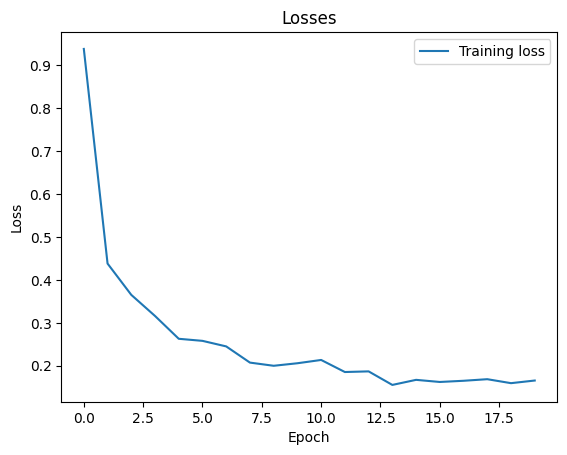

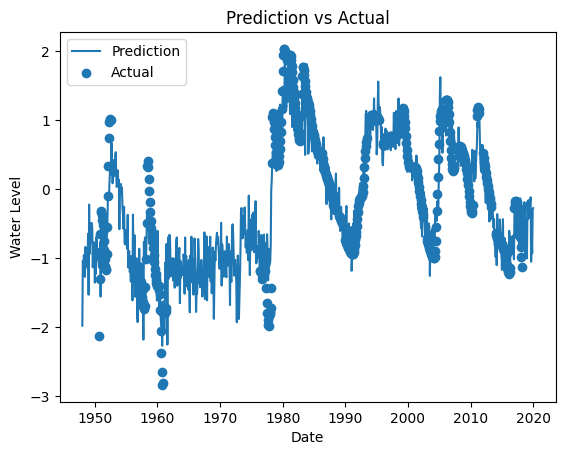

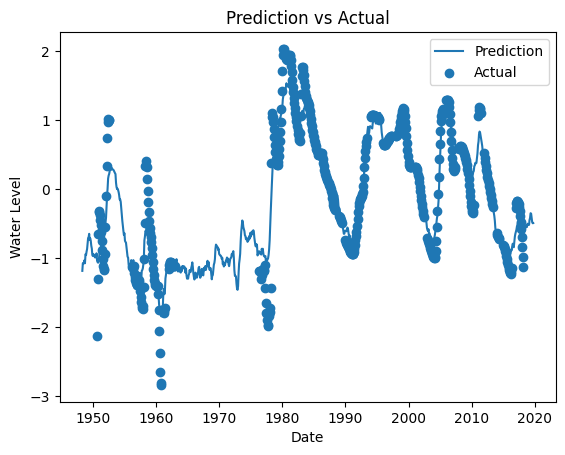

INFO:utils:Pickle file 'beryl_enterprise_imputation_satellite.pickle' saved successfully to 'artifacts/dataset_outputs'
2023-12-26 15:40:12.262 | INFO     | __main__:satellite_imputation:648 - Finished imputation for Beryl Enterprise aquifer
2023-12-26 15:40:12.263 | INFO     | __main__:satellite_imputation:649 - Added the following data to the data dictionary: Data, Predictions, Locations, Metrics
2023-12-26 15:40:12.264 | INFO     | __main__:satellite_imputation:652 - Saved data dictionary to artifacts/dataset_outputs/beryl_enterprise_imputation_satellite.pickle


test


In [3]:
def satellite_imputation(
    aquifer_name: str = "aquifer",
    pdsi_pickle: str = "pdsi.pkl",
    gldas_pickle: str = "gldas.pkl",
    well_data_pickle: str = "well_data.pkl",
    output_file: str = "output.pkl",
    timeseries_name: str = "timeseries_processed",
    locations_name: str = "locations_processed",
    validation_split: float = 0.3,
    folds: int = 5,
    batch_size: int = 32,
    regression_intercept_percentage: float = 0.15, # 0.10,
    regression_percentages: List[float] = [0.15, 0.25, 0.5, 1.0], # [0.10, 0.15, 0.25, 0.5, 1.0],
    windows: List[int] = [12, 18, 24, 36, 60], # [12, 18, 24, 36, 60],
):
    sys.path.append("..")

    # set project arguments
    project_args = utils_ml.ProjectSettings(
        aquifer_name=aquifer_name,
        iteration_current=1,
        iteration_target=1,
        artifacts_dir="artifacts",
    )

    # create metrics class
    metrics_class = utils_ml.Metrics(
        validation_split=validation_split,
        folds=folds,
    )

    # Configure logger
    logger.add(os.path.join(
            project_args.dataset_outputs_dir, "satellite_imputation_error.txt"
        ),
        level="INFO", format="{time} {level} {message}", backtrace=True, diagnose=True)

    # Load preprocessed data
    data_dict_pdsi = utils.load_pickle(
        file_name=pdsi_pickle,
        directory=project_args.dataset_outputs_dir,
    )
    data_dict_gldas = utils.load_pickle(
        file_name=gldas_pickle,
        directory=project_args.dataset_outputs_dir,
    )
    data_dict_well = utils.load_pickle(
        file_name=well_data_pickle,
        directory=project_args.dataset_outputs_dir,
    )

    # create dictionary for model outputs
    data_dict_well["runs"] = {}

    # create list of well ids and imputation range for dataframe creation
    imputation_range = utils.make_interpolation_index()
    well_ids = list(map(str, data_dict_well[timeseries_name].columns))

    # create summary metrics dataframe and imputation dataframe
    imputation_df = pd.DataFrame(
        index=imputation_range,
    )
    location_df = pd.DataFrame(
        columns=["Longitude", "Latitude"],
    )
    metrics_df = pd.DataFrame(
        index=well_ids,
        columns=metrics_class.metrics,
    )
    prediction_df = pd.DataFrame(
        index=imputation_range,
    )

    # start imputation loop
    for i, well_id in tqdm(
        enumerate(well_ids),
        total=len(well_ids),
        position=0,
        leave=False,
    ):
        logger.info(f"Starting imputation for well: {well_id}")

        try:
            # setup well object to establish indecies
            well_class = utils_ml.WellIndecies(
                well_id=well_id,
                timeseries=data_dict_well[timeseries_name][well_id],
                location=pd.DataFrame(data_dict_well[locations_name].loc[well_id]).T,
                imputation_range=imputation_range,
            )

            # parse raw and data series with corresponding indecies
            y_raw = well_class.raw_series
            y_data = well_class.data

            # create one-hot encodings for observation month
            table_dumbies = utils_ml.get_dummy_variables(y_data.index)

            # create prior features
            prior, prior_features = utils_ml.generate_priors(
                y_data=y_data,
                indecies=well_class,
                regression_percentages=regression_percentages,
                regression_intercept_percentage=regression_intercept_percentage,
                windows=windows,
            )

            # pdsi data cell selection
            table_pdsi = utils_ml.remote_sensing_data_selection(
                data_dict=data_dict_pdsi,
                location_key=locations_name,
                location_query=well_class.location,
            )

            # gldas data cell selection
            table_gldas = utils_ml.remote_sensing_data_selection(
                data_dict=data_dict_gldas,
                location_key=locations_name,
                location_query=well_class.location,
            )

            # subset GLDAS data
            table_gldas = table_gldas[
                [
                    "Psurf_f_inst",
                    "Wind_f_inst",
                    "Qair_f_inst",
                    "Qh_tavg",
                    "Qsb_acc",
                    "PotEvap_tavg",
                    "Tair_f_inst",
                    "Rainf_tavg",
                    "SoilMoi0_10cm_inst",
                    "SoilMoi10_40cm_inst",
                    "SoilMoi40_100cm_inst",
                    "SoilMoi100_200cm_inst",
                    "CanopInt_inst",
                    "SWE_inst",
                    "Lwnet_tavg",
                    "Swnet_tavg",
                ]
            ]

            # calculate surface water feature from GLDAS
            sw_names = [
                "SoilMoi0_10cm_inst",
                "SoilMoi10_40cm_inst",
                "SoilMoi40_100cm_inst",
                "SoilMoi100_200cm_inst",
                "CanopInt_inst",
                "SWE_inst",
            ]
            table_sw = pd.DataFrame(
                table_gldas[sw_names].sum(axis=1).rename("Surface Water")
            )

            # generate additional groundwater features
            gw_names = ["Qsb_acc", "SWE_inst", "Rainf_tavg"]
            table_gwf = (
                table_gldas[gw_names]
                .assign(
                    **{
                        "ln(QSB_acc)": np.log(table_gldas["Qsb_acc"]),
                        "ln(RW 4 Rainf_tavg)": np.log(
                            table_gldas["Rainf_tavg"].rolling(4, min_periods=1).sum()
                        ),
                        "Sum Soil Moist": (
                            table_sw.squeeze()
                            - table_gldas["CanopInt_inst"]
                            - table_gldas["SWE_inst"]
                        )
                        .rolling(3, min_periods=1)
                        .sum(),
                    }
                )
                .drop(columns=gw_names)
            )

            # collect feature dataframes into list: pdsi, gldas, prior features, sw, gwf, and dummies
            tables_merge = [
                table_pdsi,
                table_gldas,
                prior_features,
                table_sw,
                table_gwf,
                table_dumbies,
            ]

            # iteratively merge predictors dataframes and drop rows with missing values
            merged_df = reduce(
                lambda left, right: pd.merge(
                    left=left,
                    right=right,
                    left_index=True,
                    right_index=True,
                    how="left",
                ),
                tables_merge,
            ).dropna()

            # merge features with labels
            well_set = y_data.to_frame(name=well_id).join(merged_df, how="outer")

            # match timeseries index by droping missing rows not in the label set
            well_set_clean = well_set.dropna()

            # split dataframe into features and labels
            y, x = utils_ml.dataframe_split(well_set_clean, well_id)

            # specify features that will be passed through without scaling
            features_to_pass = table_dumbies.columns.to_list()

            # create scaler object
            scaler_features = StandardScaler()
            scaler_labels = StandardScaler()

            # Create folds to split data into train, validation, and test sets
            n_epochs = []
            n_folds = folds
            current_fold = 1

            (y_kfold, x_kfold) = (y.to_numpy(), x.to_numpy())
            kfold = KFold(n_splits=n_folds, shuffle=False)
            temp_metrics = pd.DataFrame(columns=metrics_class.metrics)
            model_runs = pd.DataFrame(index=imputation_range)

            # train k-folds grab error metrics average results
            logger.info(f"Starting k-fold cross validation for well: {well_id}")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            for train_index, test_index in kfold.split(y_kfold, x_kfold):
                x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index, :]

                # Create validation and training sets
                x_train, x_val, y_train, y_val = train_test_split(
                    x_train, y_train, test_size=0.30, random_state=42
                )

                # Create scaler for features and labels
                x_train, scaler_features = utils_ml.scaler_pipeline(
                    x=x_train,
                    scaler_object=scaler_features,
                    features_to_pass=features_to_pass,
                    train=True,
                )

                x_val = utils_ml.scaler_pipeline(
                    x=x_val,
                    scaler_object=scaler_features,
                    features_to_pass=features_to_pass,
                    train=False,
                )
                x_test = utils_ml.scaler_pipeline(
                    x=x_test,
                    scaler_object=scaler_features,
                    features_to_pass=features_to_pass,
                    train=False,
                )

                # create predictors for full time series
                x_pred_temp = utils_ml.scaler_pipeline(
                    x=merged_df,
                    scaler_object=scaler_features,
                    features_to_pass=features_to_pass,
                    train=False,
                )

                # Transform Y values
                y_train = pd.DataFrame(
                    scaler_labels.fit_transform(y_train),
                    index=y_train.index,
                    columns=y_train.columns,
                )
                y_val = pd.DataFrame(
                    scaler_labels.transform(y_val),
                    index=y_val.index,
                    columns=y_val.columns,
                )
                y_test = pd.DataFrame(
                    scaler_labels.transform(y_test),
                    index=y_test.index,
                    columns=y_test.columns,
                )

                # Convert data to PyTorch tensors
                x_train_tensor = torch.tensor(
                    x_train.values,
                    dtype=torch.float32,
                ).to(device)
                x_val_tensor = torch.tensor(
                    x_val.values,
                    dtype=torch.float32,
                ).to(device)
                x_test_tensor = torch.tensor(
                    x_test.values,
                    dtype=torch.float32,
                ).to(device)
                x_pred_tensor = torch.tensor(
                    x_pred_temp.values,
                    dtype=torch.float32,
                ).to(device)
                y_train_tensor = torch.tensor(
                    y_train.values,
                    dtype=torch.float32,
                ).to(device)
                y_val_tensor = torch.tensor(
                    y_val.values,
                    dtype=torch.float32,
                ).to(device)

                # Define PyTorch DataLoader for training
                train_dataset = CustomDataset(x_train_tensor, y_train_tensor)
                val_dataset = CustomDataset(x_val_tensor, y_val_tensor)
                train_loader = DataLoader(
                    train_dataset, batch_size=batch_size, shuffle=True
                )
                val_loader = DataLoader(
                    val_dataset, batch_size=batch_size, shuffle=False
                )

                # Model Initialization
                train_losses = []
                val_losses = []
                input_dim = x_train.shape[1]
                hidden_dim = 64
                patience = 5
                model = NeuralNetwork(input_dim, hidden_dim).to(device)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(
                    model.parameters(),
                    lr=0.001,
                    weight_decay=0.1,
                )
                scheduler = ReduceLROnPlateau(
                    optimizer=optimizer,
                    factor=0.1,
                    patience=5,
                    min_lr=0,
                )

                early_stopper = EarlyStopper(patience=patience)

                # Training loop
                epochs = 700
                for epoch in range(epochs):
                    # Training
                    train_loss = utils_model.train_regression(
                        model,
                        train_loader,
                        optimizer,
                        criterion,
                        device,
                    )
                    train_losses.append(train_loss)

                    # Validation
                    val_loss = utils_model.validate_regression(
                        model,
                        val_loader,
                        criterion,
                        device,
                    )
                    val_losses.append(val_loss)

                    # Adjust learning rate
                    scheduler.step(val_loss)

                    # Early Stopping
                    if early_stopper.early_stop(val_loss, model):
                        n_epochs.append(epoch)
                        break
                early_stopper.restore_best_weights(model)

                # # Plot losses
                # plt.plot(train_losses, label='Training loss')
                # plt.plot(val_losses, label='Validation loss')
                # plt.xlabel('Epoch')
                # plt.ylabel('Loss')
                # plt.title('Losses')
                # plt.legend()

                # Prediction
                y_train_hat = model(x_train_tensor).cpu().detach().numpy()
                y_val_hat = model(x_val_tensor).cpu().detach().numpy()
                y_test_hat = model(x_test_tensor).cpu().detach().numpy()
                y_pred_hat = model(x_pred_tensor).cpu().detach().numpy()

                # Metrics Calculation
                train_points, val_points = [len(y_train)], [len(y_val)]

                train_me = np.mean(y_train_hat - y_train.values)
                val_me = np.mean(y_val_hat - y_val.values)

                train_rmse = mean_squared_error(y_train.values, y_train_hat, squared=False)
                val_rmse = mean_squared_error(y_val.values, y_val_hat, squared=False)

                train_mae = mean_absolute_error(y_train.values, y_train_hat)
                val_mae = mean_absolute_error(y_val.values, y_val_hat)

                # compile errors
                train_e = [train_me, train_rmse, train_mae]
                val_e = [val_me, val_rmse, val_mae]

                test_cols = ["Test ME", "Test RMSE", "Test MAE"]

                train_errors = np.array([train_e + val_e]).reshape((1, 6))
                errors_col = [
                    "Train ME",
                    "Train RMSE",
                    "Train MAE",
                    "Validation ME",
                    "Validation RMSE",
                    "Validation MAE",
                ]
                df_metrics = pd.DataFrame(
                    train_errors, index=([str(current_fold)]), columns=errors_col
                )

                df_metrics["Train Points"] = train_points
                df_metrics["Validation Points"] = val_points

                df_metrics["Train r2"], _ = pearsonr(
                    y_train.squeeze(),
                    y_train_hat.squeeze(),
                )
                df_metrics["Validation r2"], _ = pearsonr(
                    y_val.squeeze(),
                    y_val_hat.squeeze(),
                )
                temp_metrics = pd.concat(
                    objs=[
                        temp_metrics,
                        df_metrics,
                    ]
                )
                # print(temp_metrics)
                logger.info(f"{temp_metrics}")

                # Model Prediction
                prediction_temp = pd.DataFrame(
                    scaler_labels.inverse_transform(y_pred_hat),
                    index=x_pred_temp.index,
                    columns=[current_fold],
                )

                # append prediction to model runs
                model_runs = model_runs.join(prediction_temp, how="outer")

                # Test Predictions and Error Metrics
                try:
                    # Test Error Metrics
                    test_points = len(y_test)
                    test_me = np.mean(y_test_hat.values - y_test.values)
                    test_rmse = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                    test_mae = mean_absolute_error(y_test.values, y_test_hat.values)
                    test_errors = np.array([test_me, test_rmse, test_mae]).reshape(
                        (1, 3)
                    )
                    # concatenate test errors
                    test_cols = ["Test ME", "Test RMSE", "Test MAE"]
                    test_metrics = pd.DataFrame(
                        test_errors, index=[str(current_fold)], columns=test_cols
                    )
                    test_metrics["Test Points"] = test_points
                    test_metrics["Test r2"], _ = pearsonr(
                        y_test.squeeze(), y_test_hat.squeeze(),
                    )
                    temp_metrics.loc[
                        str(current_fold), test_metrics.columns
                    ] = test_metrics.loc[str(current_fold)]

                except:
                    temp_metrics.loc[
                        str(current_fold), ["Test ME", "Test RMSE", "Test MAE"]
                    ] = np.NAN
                    temp_metrics.loc[str(current_fold), "Test Points"] = 0
                    temp_metrics.loc[str(current_fold), "Test r2"] = np.NAN

                current_fold += 1

            # Log metrics
            logger.info(f"Finished k-fold cross validation for well: {well_id}")

            # Reset feature scalers
            x, scaler_features = utils_ml.scaler_pipeline(
                x,
                scaler_features,
                features_to_pass,
                train=True,
            )
            x_pred = utils_ml.scaler_pipeline(
                merged_df,
                scaler_features,
                features_to_pass,
                train=False,
            )
            y = pd.DataFrame(
                scaler_labels.fit_transform(y),
                index=y.index,
                columns=y.columns,
            )

            # Convert data to PyTorch tensors
            x_tensor = torch.tensor(x.values, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)
            x_pred_tensor = torch.tensor(x_pred.values, dtype=torch.float32).to(device)

            # Define PyTorch DataLoader for training
            train_dataset = CustomDataset(x_tensor, y_tensor)
            train_loader_full = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True
            )

            # Retrain Model with number of epochs from k-fold cross validation
            model_full = NeuralNetwork(input_dim, hidden_dim).to(device)
            optimizer_full = optim.Adam(
                    model_full.parameters(),
                    lr=0.001,
                    weight_decay=0.1,
                )
            scheduler_full = ReduceLROnPlateau(
                    optimizer=optimizer_full,
                    factor=0.1,
                    patience=5,
                    min_lr=0,
                )

            # Final Training loop
            epochs_average_k_fold = int(sum(n_epochs) / len(n_epochs))
            full_train_losses = []
            for epoch_full in range(epochs_average_k_fold):
                train_loss_full = utils_model.train_regression(
                    model_full, train_loader_full, optimizer_full, criterion, device
                )
                scheduler_full.step(train_loss_full)
                full_train_losses.append(train_loss_full)
            logger.info(f"Full Well Training: Epoch: {epoch_full} | Train Loss: {train_loss_full}")

            # Prediction
            y_hat = model_full(x_tensor).cpu().detach().numpy()
            y_pred_hat = model_full(x_pred_tensor).cpu().detach().numpy()

            # # Plot losses
            plt.plot(full_train_losses, label='Training loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Losses')
            plt.legend()
            plt.show()

            # plot the prediction
            plt.plot(x_pred.index, y_pred_hat, label='Prediction')
            plt.scatter(y.index, y, label='Actual')
            plt.xlabel('Date')
            plt.ylabel('Water Level')
            plt.title('Prediction vs Actual')
            plt.legend()
            plt.show()

            test = pd.DataFrame(y_pred_hat, index = x_pred.index)

            # plot the prediction smoothed
            plt.plot(x_pred.index, test.rolling(window=8, center=True).mean(), label='Prediction')
            plt.scatter(y.index, y, label='Actual')
            plt.xlabel('Date')
            plt.ylabel('Water Level')
            plt.title('Prediction vs Actual')
            plt.legend()
            plt.show()
            print("test")
            break



            metrics_avg = pd.DataFrame(
                temp_metrics.mean(), columns=[well_id]
            ).transpose()
            metrics_df = pd.concat(objs=[metrics_df, metrics_avg])

            # Model Prediction
            prediction = pd.DataFrame(
                scaler_labels.inverse_transform(y_pred_hat).astype(float),
                index=x_pred.index,
                columns=[well_id],
            )

            # append location to location dataframe
            location_df = pd.concat(
                [location_df, well_class.location], axis=0, ignore_index=False
            )

            # append prediction to prediction dataframe
            prediction_df = prediction_df.join(prediction, how="outer")

            # append prediction to model runs
            model_runs = model_runs.join(prediction, how="outer")
            data_dict_well["runs"][well_id] = model_runs

            # calculate spread and comp r2
            spread = pd.DataFrame(index=prediction.index, columns=["mean", "std"])
            spread["mean"] = model_runs.mean(axis=1)
            spread["std"] = model_runs.std(axis=1)
            comp_r2 = r2_score(
                scaler_labels.inverse_transform(y.values.reshape(-1, 1)),
                scaler_labels.inverse_transform(y_train_hat),
            )
            metrics_df.loc[well_id, "Comp R2"] = comp_r2

            # Data Filling
            gap_time_series = pd.DataFrame(
                data_dict_well["timeseries"][well_id], index=prediction.index
            )
            filled_time_series = gap_time_series[well_id].fillna(prediction[well_id])
            if y_raw.dropna().index[-1] > prediction.index[-1]:
                filled_time_series = pd.concat(
                    [filled_time_series, y_raw.dropna()], join="outer", axis=1
                )
                filled_time_series = filled_time_series.iloc[:, 0]
                filled_time_series = filled_time_series.fillna(y_raw)
            imputation_df = imputation_df.join(filled_time_series, how="outer")
            logger.info(f"Finished model training for well: {well_id}")

        except (
            ValueError,
            TypeError,
            KeyError,
            IndexError,
            FileNotFoundError,
            PermissionError,
            ConnectionError,
            Exception,
        ) as error:
            logger.error(f"An exception ocurred on well: {well_id}\n{error}")
            logger.error(traceback.format_exc())
            continue

    # build output dictionary
    data_dict_well["Data"] = imputation_df.loc[imputation_range]
    data_dict_well["Predictions"] = prediction_df.loc[imputation_range]
    data_dict_well["Locations"] = location_df
    data_dict_well["Metrics"] = metrics_df

    utils.save_pickle(
        data_dict_well,
        output_file,
        project_args.dataset_outputs_dir,
    )
    logger.info(f"Finished imputation for {aquifer_name} aquifer")
    logger.info(
        "Added the following data to the data dictionary: Data, Predictions, Locations, Metrics"
    )
    logger.info(
        f"Saved data dictionary to {project_args.dataset_outputs_dir}/{output_file}"
    )


satellite_imputation(
    aquifer_name=Config.aquifer_name,
    pdsi_pickle=Config.pdsi_file_name,
    gldas_pickle=Config.gldas_file_name,
    well_data_pickle=Config.well_data_file_name,
    output_file=Config.satellite_imputation_output_file,
    timeseries_name=Config.well_data_timeseries_name,
    locations_name=Config.well_data_locations_name,
    validation_split=Config.validation_split,
    folds=Config.folds,
    batch_size=Config.batch_size,
)